In [1]:
import numpy as np
from numba import njit
import pickle
import time, sys

from scipy.optimize import curve_fit
from scipy.interpolate import splrep, splev

import matplotlib.pyplot as plt

In [34]:
n_orb = 4

def FockState(index, n_orb):
    return np.array(list(np.binary_repr(index - 1, width=2*n_orb)), dtype=int)

def FockIndex(bin_):
    return int("".join(str(x) for x in bin_), 2) + 1

def FermiCop(flavor, n_orb):
    def condition(index):
        return FockState(index, n_orb)[flavor-1] == 0

    indices = [index for index in range(1, 4**n_orb + 1) if condition(index)]
    sum_matrix = np.zeros((4**n_orb, 4**n_orb))
    for index in indices:
        state = FockState(index, n_orb)
        phase = (-1)**np.sum(state[:flavor])
        updated_state = np.copy(state)
        updated_state[flavor-1] = 1
        sum_matrix += phase * np.outer(np.eye(4**n_orb)[index-1], np.eye(4**n_orb)[FockIndex(updated_state)-1])
    return sum_matrix

def FillBasis(occu, n_orb):
    def condition(index):
        return np.sum(FockState(index, n_orb)) == occu

    return [np.eye(4**n_orb)[index-1] for index in range(1, 4**n_orb + 1) if condition(index)]

cun = np.array([FermiCop(i, n_orb) for i in range(1, n_orb+1)]).astype(np.csingle)
cdn = np.array([FermiCop(i, n_orb) for i in range(n_orb+1, 2*n_orb+1)]).astype(np.csingle)
cn = np.array([FermiCop(i, n_orb) for i in range(1, 2*n_orb+1)]).astype(np.csingle)


In [35]:
@njit
def nonintmat(kx, n_orb):
    A = np.exp(1j * kx / n_orb)
    mat = np.zeros((n_orb, n_orb), dtype=np.csingle)

    for i in range(n_orb):
        for j in range(n_orb):
            if i - j == 1:
                mat[i, j] += 1 / A
            if j - i == 1:
                mat[i, j] += A

    mat[0, n_orb - 1] += 1/A
    mat[n_orb - 1, 0] += A

    return mat

@njit
def hamiltonian(nonint, mu, U, n_orb):
    nonint_term = np.zeros((4**n_orb, 4**n_orb), dtype=np.csingle)
    U_term = np.zeros((4**n_orb, 4**n_orb), dtype=np.csingle)
    mu_term = np.zeros((4**n_orb, 4**n_orb), dtype=np.csingle)
    
    for i in range(n_orb):
        for j in range(n_orb):
            nonint_term += np.dot(cun[i].T, cun[j]) * nonint[i, j]
            nonint_term += np.dot(cdn[i].T, cdn[j]) * nonint[i, j]
        U_term += np.dot(np.dot(cun[i].T , cun[i]) ,np.dot( cdn[i].T ,cdn[i])) * U
    for i in range(2*n_orb):
        mu_term += -mu * (cn[i].T @ cn[i])


    # Total Hamiltonian
    H = nonint_term + mu_term + U_term
    return H


@njit
def fullhamil(kx, t, mu, U, n_orb):
    return hamiltonian(-t * nonintmat(kx, n_orb), mu, U, n_orb)

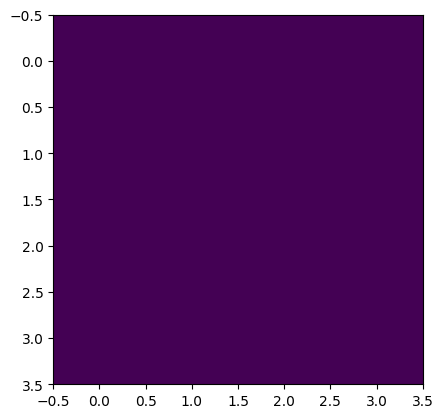

In [191]:
#plt.imshow(nonintmat(1,1).imag)
plt.imshow(fullhamil(1, 1, 3, 6, 1).imag)

In [11]:
lcm = 120
corr_func_final = np.zeros(shape=(3, lcm), dtype=complex)

In [41]:
k_num = 50
U = 6
mu = U/2
t = 1

norb_list = np.array([4])#np.arange(4, 22, 4)
mu_dict = {1:-0.6, 2:0.13, 4:0.95}

for orb_ind, norb in enumerate(norb_list):
    
    corr_func_temp = np.zeros(lcm, dtype=complex)
    for kx in range(-int(k_num/2), int(k_num/2)):
        mu=mu_dict[norb]
        tvals, tvecs = np.linalg.eigh(fullhamil(kx*np.pi/k_num,  t, mu, U, norb))
        #print(tvals)
        exp_func_k = np.zeros(lcm, dtype=complex)
        gs_vec = tvecs[:,0]#(tvecs[:,0]+tvecs[:,1])/np.sqrt(2)
        acc = 1
        while True:
            if tvals[0]==tvals[acc]:
                gs_vec+=tvecs[:, acc]
                acc+=1
                #print("Sad")
            else:
                break
        gs_vec = gs_vec/np.sqrt(acc)
        for r in range(lcm):
            exp_func_k[r] = np.conj(gs_vec.T) @ cun[r%norb] @ cun[0].T @ gs_vec * np.exp(1j*kx/k_num*np.pi*r)
        corr_func_temp+=exp_func_k
    corr_func_final[2, :] = corr_func_temp/k_num
    print(norb)

4


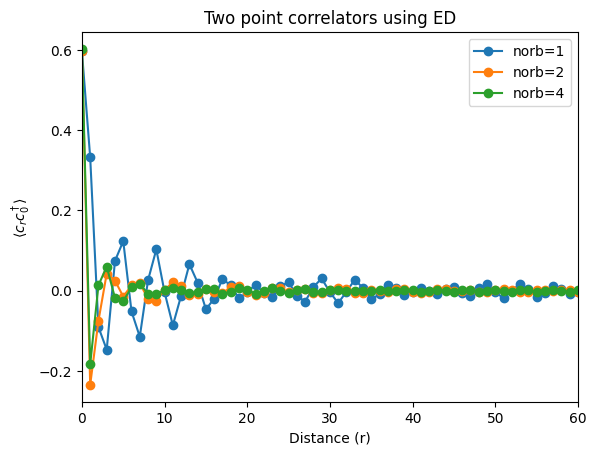

In [46]:
norb_list = np.array([1, 2, 4])

for ind, norb in enumerate(norb_list):
    #if ind==0: continue
    plt.plot(np.arange(lcm)[:], corr_func_final[ind, :].real, marker='o', label="norb="+str(norb))
    #plt.plot(np.arange(lcm)[:], corr_func_dmrg.real, marker='o', label="DMRG")
    
plt.xlim(0, 60)
plt.legend()
#plt.xscale('log')
x = np.linspace(0, 100)
y = 0.5*np.exp(-x/12)
#plt.plot(x, y)
#plt.yscale('log')

plt.ylabel(r"$\langle c_r c_0^\dagger\rangle$")
plt.xlabel("Distance (r)")
plt.title("Two point correlators using ED")
plt.savefig("Fig1.png")

In [238]:
import pickle

data_dict = {}
data_dict['corr_func_ED'] = corr_func_final
data_dict['norb_list'] = norb_list

with open('Corr_func_ED.pkl', 'wb') as file:
    pickle.dump(data_dict, file)

(0.0, 50.0)

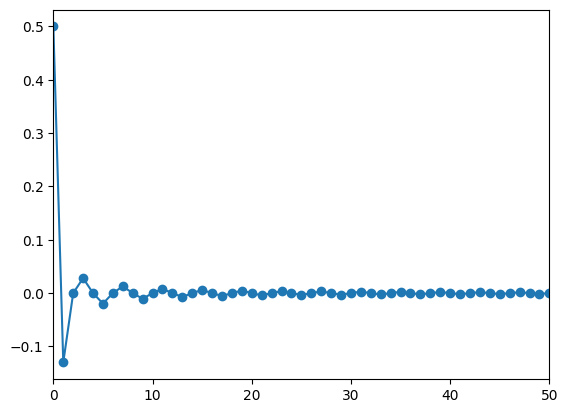

In [124]:
plt.plot(np.arange(lcm)[:], corr_func_final[2, :].real, marker='o', label="norb="+str(norb))
#plt.plot(np.arange(lcm)[:], corr_func_dmrg.real, marker='o', label="norb="+str(norb))

plt.xlim(0, 50)

In [38]:
k_num = 100
U = 6
mu = U/2
t = 1

mu_range = np.linspace(0.5, 1.2, 20)
occupancy = np.zeros_like(mu_range)

for mu_ind, mu in enumerate(mu_range):
    for kx in range(-int(k_num/2), int(k_num/2)):
        tvals, tvecs = np.linalg.eigh(fullhamil(kx*np.pi/k_num,  t, mu, U, n_orb))
        #print(tvals)
        #Z = np.exp(-beta*tvals).sum()
        #gs_vec = np.einsum('ij,j->i', tvecs, np.exp(-beta*tvals/2))/np.sqrt(Z)
        #print(check_degenerate_eigenvalues(fullhamil(kx*np.pi/k_num,  t, mu, U, n_orb)))
        gs_vec = tvecs[:, 0]
        acc = 1
        while True:
            if tvals[0]==tvals[acc]:
                gs_vec+=tvecs[:, acc]
                acc+=1
                #print("Sad")
            else:
                break
        #print(acc)
        gs_vec = gs_vec/np.sqrt(acc)
        for i in range(n_orb):
            occupancy[mu_ind]+= (np.conj(gs_vec.T) @ cun[i].T @ cun[i] @ gs_vec).real
            occupancy[mu_ind]+= (np.conj(gs_vec.T) @ cdn[i].T @ cdn[i] @ gs_vec).real
    #print(mu)

occupancy = occupancy/k_num/n_orb

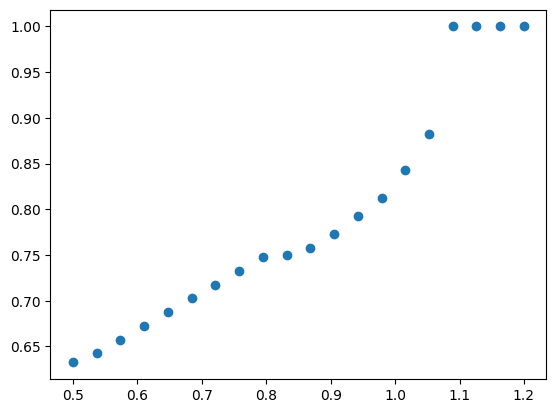

In [39]:
plt.scatter(mu_range, occupancy)

In [315]:
import numpy as np

def check_degenerate_eigenvalues(matrix):
    """
    Checks for degenerate eigenvalues in a given matrix.

    Args:
        matrix (numpy.ndarray): A square matrix.

    Returns:
        tuple: A tuple containing:
            - bool: True if degenerate eigenvalues exist, False otherwise.
            - numpy.ndarray: The eigenvalues of the matrix.
    """
    eigenvalues = np.linalg.eigvals(matrix)
    unique_eigenvalues = np.unique(eigenvalues)
    if len(eigenvalues) != len(unique_eigenvalues):
        return True, eigenvalues
    else:
        return False, eigenvalues

# Example usage:
matrix1 = np.array([[1, 0, 0],
                    [0, 2, 0],
                    [0, 0, 2]])

matrix2 = np.array([[1, 0],
                    [0, 2]])

has_degenerate1, eigenvalues1 = check_degenerate_eigenvalues(matrix1)
has_degenerate2, eigenvalues2 = check_degenerate_eigenvalues(matrix2)

print(f"Matrix 1 has degenerate eigenvalues: {has_degenerate1}")
print(f"Eigenvalues of Matrix 1: {eigenvalues1}")
print(f"Matrix 2 has degenerate eigenvalues: {has_degenerate2}")
print(f"Eigenvalues of Matrix 2: {eigenvalues2}")

Matrix 1 has degenerate eigenvalues: True
Eigenvalues of Matrix 1: [1. 2. 2.]
Matrix 2 has degenerate eigenvalues: False
Eigenvalues of Matrix 2: [1. 2.]


In [274]:
beta = 25
np.exp(-beta*tvals)

array([3.3665508e+35, 2.3408270e+27, 2.3408270e+27, 5.1847055e+21,
       5.1847055e+21, 5.1847055e+21, 1.0000000e+00, 2.2149115e-06,
       2.2149115e-06, 8.7080208e-17, 8.7080208e-17, 3.7835059e-44,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [ ]:
tvecs[:, 0]

array([ 1.0000000e+00+0.0000000e+00j,  1.6552147e+27+0.0000000e+00j,
        1.6552147e+27-1.2170936e+19j,  5.1847055e+21+0.0000000e+00j,
        1.6552147e+27+0.0000000e+00j,  9.1855260e+34+6.7541971e+26j,
        2.1961542e+35+0.0000000e+00j, -1.8688111e+19+5.6819087e+09j,
        1.6552147e+27-1.2170936e+19j,  2.1961542e+35-8.7209503e+09j,
        9.1855260e+34-6.7541971e+26j,  4.1284573e+17+4.5405414e+09j,
        5.1847055e+21+0.0000000e+00j, -6.1575007e-17+0.0000000e+00j,
       -6.1575007e-17+4.5276632e-25j,  0.0000000e+00+0.0000000e+00j],
      dtype=complex64)